# Analysing chemistry space of the APOGEE RC catalogue 
### with t-SNE, UMAP, and PCA 

In [1]:
import numpy as np
#import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter


import astropy.table
from astropy.table import Table, Column, MaskedColumn 
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde
import seaborn as sns
import os.path

from time import time
from sklearn import manifold, datasets

import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import product

import obtain_data

#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=16, usetex=True)

## Preparing the sample on which to run tSNE, PCA and UMAP

### The APOGEE DR16 RC sample
The [DR16 red-clump catalogue](https://www.sdss.org/dr16/data_access/value-added-catalogs/?vac_id=apogee-red-clump-(rc)-catalog) is a very clean selection of RC stars from APOGEE DR16. The first version of the catalogue dates back to DR11 and has since been continuously maintained & updated by Jo Bovy (Toronto).


In [2]:
import importlib
importlib.reload(obtain_data)

apo_rc = obtain_data.apogeedr16_rc()

16193 stars in your APOGEE DR16 sample all


In [3]:
apo_rc.get_umap_tsne_colours(p=80, lr=100, nn=100, md=0.1, metric="euclidean")

### Prepare the input arrays for PCA, t-SNE, and umap...

... for all the samples used here. We use the functions built into `open_data.py`. 

In [4]:
# Decide on what to use as input for the dimensionality reduction code:
cn       = True    # only applicable for APOGEE (not enough stars with C/N measured for Bensby & HARPS)
feh      = True    # whether to include Fe/H as a dimension - currently not implemented for APOGEE!
norm     = "stdev" # other possible choices: "hogg2016" or None

# Define some useful names
data     = [apo_rc]
dataname = ["APOGEE DR16 RC"]
idcol    = ["APOGEE_ID"]
tname    = ["apogee_rc"]

Xlist, Xerrlist, Xnormlist = [], [], []

for ii in [0]:
    data[ii].get_ndimspace(cn=cn, norm=norm)
    X, Xerr, Xnorm = data[ii].X, data[ii].Xerr, data[ii].Xnorm
    Xlist.append(X); Xerrlist.append(Xerr); Xnormlist.append(Xnorm)

## Clustering in umap space

Read the umap output file:

In [5]:
results = Table.read("../data/dimred_results/apogee_rc_dimred_hyperparametertest.fits")

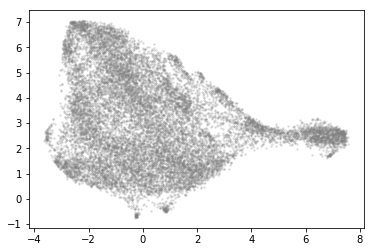

In [6]:
colstring = "umap_euclidean_nn100_md0.1"
scat = plt.scatter(results["X_"+colstring], results["Y_"+colstring], s=5, lw=0, c="grey", alpha=0.3)

data = results["X_"+colstring, "Y_"+colstring].to_pandas().to_numpy()
dataid = results["ID","X_"+colstring, "Y_"+colstring].to_pandas().to_numpy()

## Copying from the HDBSCAN tutorial

In [7]:
import hdbscan
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 40, 'linewidths':0}

def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)



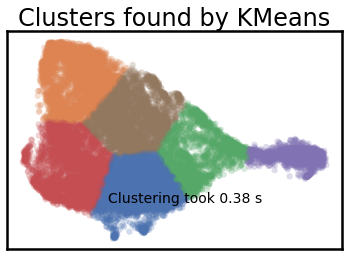

In [8]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters':6})

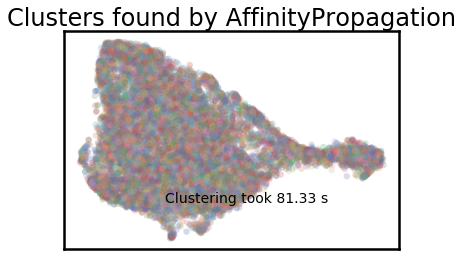

In [9]:
plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

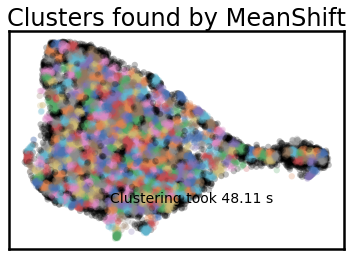

In [10]:
plot_clusters(data, cluster.MeanShift, (0.175,), {'cluster_all':False})

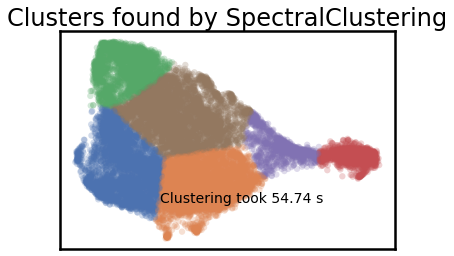

In [11]:
plot_clusters(data, cluster.SpectralClustering, (), {'n_clusters':6})

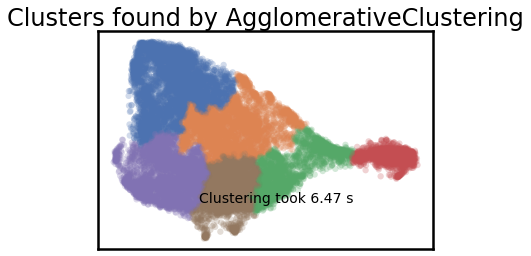

In [12]:
plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

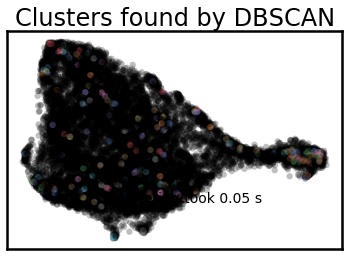

In [13]:
plot_clusters(data, cluster.DBSCAN, (), {'eps':0.025})

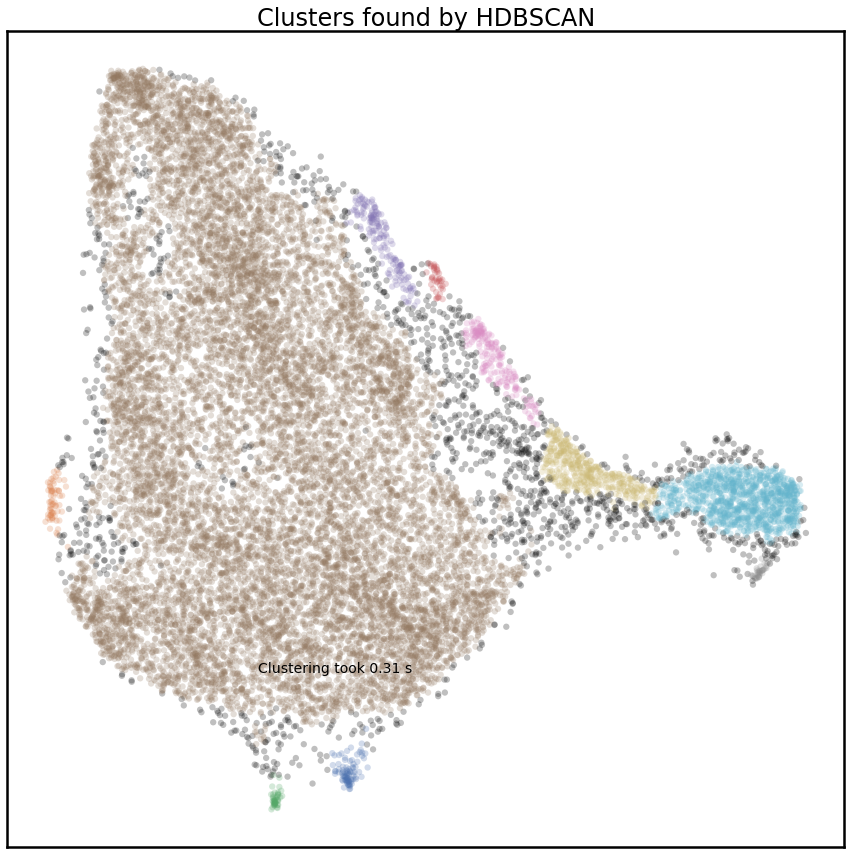

In [14]:
plt.figure(figsize=(15,15))
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':30, "min_samples":20})

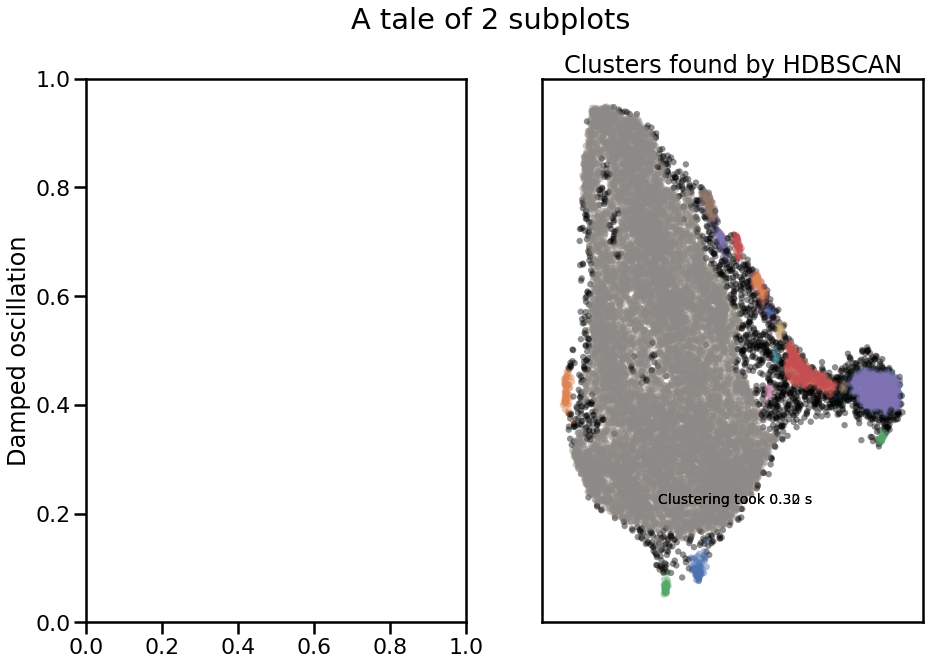

In [15]:
x1 = np.linspace(0.0, 5.0)
x2 = np.linspace(0.0, 2.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('A tale of 2 subplots')

fig.set_figheight(10)
fig.set_figwidth(15)

plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':30, "min_samples":20})
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':5, "min_samples":20})
ax1.set_ylabel('Damped oscillation')
#ax2.plot(x2, y2, '.-')
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Undamped')

plt.show()

### Extracting the clusters

In [16]:
#algorithm(*args, **kwds).fit_predict(data)

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, min_samples=15,
    metric='euclidean', min_cluster_size=30, p=None)
clusterer.fit(data)

print(clusterer.labels_)
print(np.unique(clusterer.labels_))

[ 6  6  6 ... 11  6 -1]
[-1  0  1  2  3  4  5  6  7  8  9 10 11]


## Prepare the big plot

The above is now implemented in obtain_data.apogeedr16_rc(). So we simply call:

In [17]:
importlib.reload(obtain_data)

apo_rc = obtain_data.apogeedr16_rc()
apo_rc.get_umap_tsne_colours(p=80, lr=100, nn=100, md=0.1,)
apo_rc.get_umap_subsets(nn=100, md=0.1, min_samples=15, min_cluster_size=30)
print(apo_rc.classcol)
#datasubs = results["ID","X_"+colstring, "Y_"+colstring].to_pandas().to_numpy
#datasubs = results["ID"].to_numpy
print(results["ID"])

16193 stars in your APOGEE DR16 sample all
[ 6  6  6 ... 11  6 -1]
        ID        
------------------
2M00000211+6327470
2M00000446+5854329
2M00001199+6114138
2M00002012+5612368
2M00002338+6457409
2M00003456+1538435
2M00003498+5800176
2M00004849+8521299
2M00004872+5647031
2M00010552+5815566
               ...
2M23574689+7416079
2M23575557+7419408
2M23580101+6221364
2M23581639+6356411
2M23581889+6303189
2M23582454+6222497
2M23583624+7405505
2M23585212+6403065
2M23590602-1934447
2M23594182+5637552
2M23594866+6258182
Length = 16193 rows


Now we can adapt Fig. 1 from Anders+2018 for our sample, using the automatically found clusters as subgroups: 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


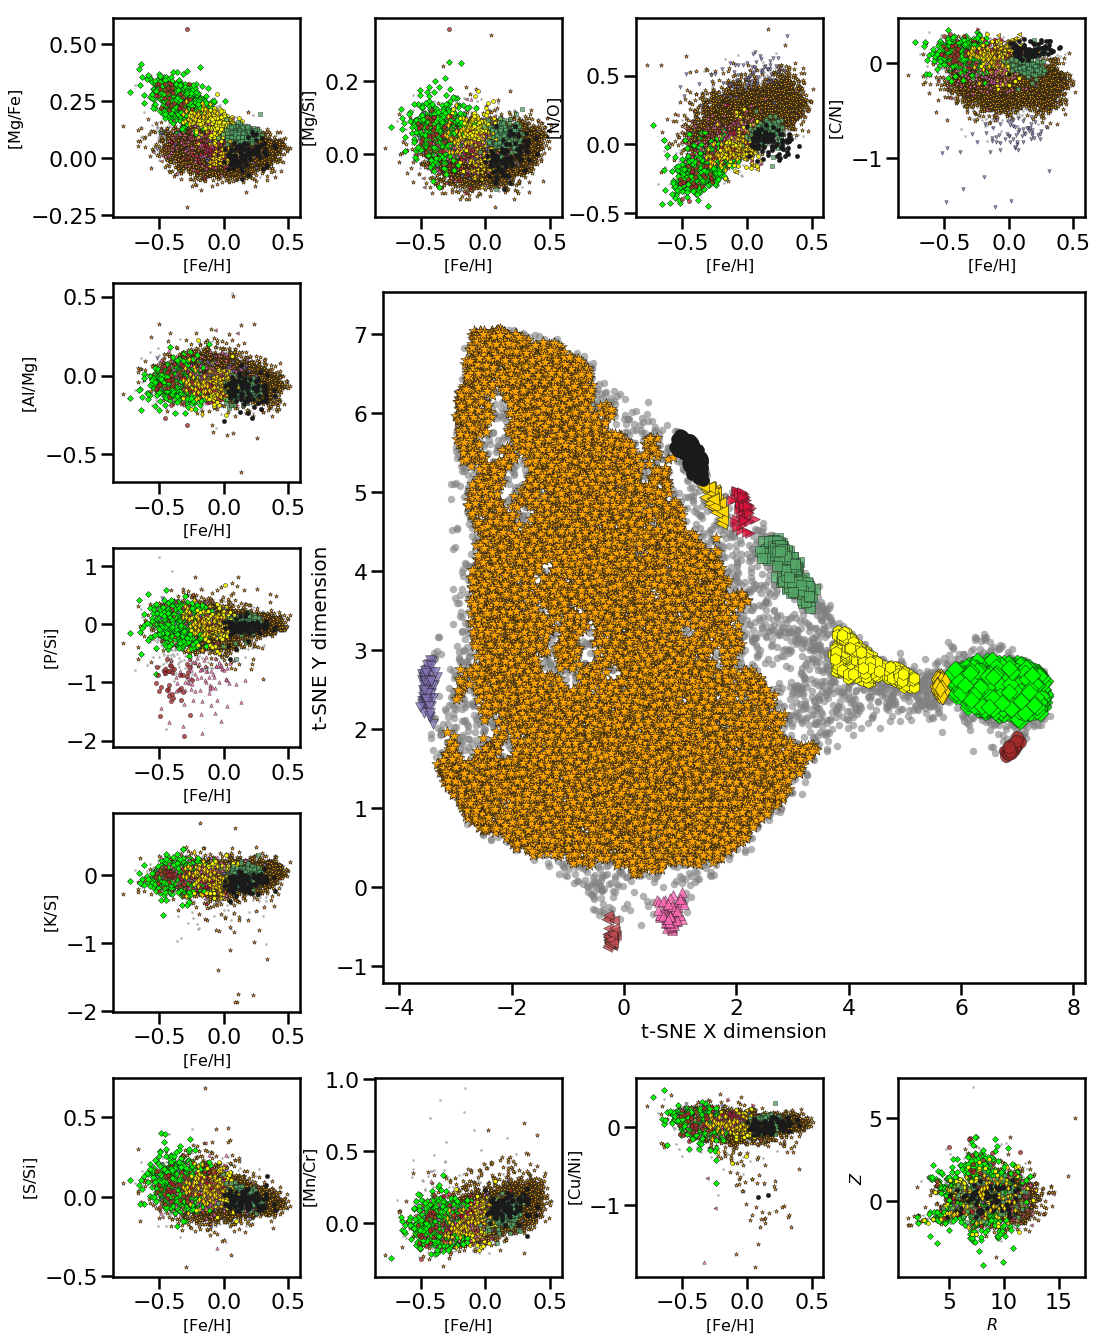

In [19]:
t = apo_rc

# t-SNE + abundances plot

exinds = [ [0,1], [0,2], [0,4], [0,5],
           [0,6], None,  None,  None, 
           [0,7], None,  None,  None, 
           [0,8], None,  None,  None, 
           [0,9],[0,10],[0,11],[13,14] ]
limits = [ None,  None,  None,  None, 
           None,  None,  None,  None, 
           None,  None,  None,  None, 
           None,  None,  None,  None, 
           None,  None,  None,  None ]

order=[0,7,12,10,1,2,3,4,5,6,8,9,11] # I define the order in which the plot is to be made so that the smaller groups may be seen
#------------------------------------------------------------
# Plot the results
import matplotlib.gridspec as gridspec

g   = plt.figure(figsize=(15, 19))

#################
# abundance plots around
#################
gs = gridspec.GridSpec(5, 4)
gs.update(left=0.08, bottom=0.06, right=0.98, top=0.98,
           wspace=0.4, hspace=0.33)

for jj in range(20):
    print(jj)
    if exinds[jj] != None:
        ax = plt.subplot(gs[int(jj/4), int(jj%4)])
        g.add_subplot(ax)
        for kk in order:
            mask = (t.classcol == t.subsets[kk]) #* (xerr[exinds[jj][1]] < 9.9)
            #ax.errorbar(xx[exinds[jj][0]][mask], xx[exinds[jj][1]][mask],
            #            xerr=xerr[exinds[jj][0]][mask], yerr=xerr[exinds[jj][1]][mask],
            #           ms=0, mec="k", capthick=0, elinewidth=1,
            #           mfc=t.col[kk], alpha=t.al[kk]/4., ecolor=t.col[kk], lw=0,
            #           marker=t.sym[kk], zorder=0)
            ax.scatter(t.colors[exinds[jj][0]][mask], t.colors[exinds[jj][1]][mask],
                       s=t.size[kk], lw=t.lw[kk], edgecolors="k",
                       c=t.col[kk], alpha=t.al[kk],
                       marker=t.sym[kk])
        ax.set_xlabel(t.titles[exinds[jj][0]], fontsize=16)
        ax.set_ylabel(t.titles[exinds[jj][1]], fontsize=16)
        if limits[jj] != None:
            ax.axis(limits[jj])
        ax.locator_params(tight=True, nbins=4)

#################
# t-SNE plot in the center
#################
gs0 = gridspec.GridSpec(1, 1)
gs0.update(left=0.33, bottom=0.275, right=0.98, top=0.78)
ax  = plt.Subplot(g, gs0[0, 0])
g.add_subplot(ax)
for kk in order:
    mask = (t.classcol == t.subsets[kk])
    ax.scatter(t.Xu[mask], t.Yu[mask], s=8*t.size[kk], lw=t.lw[kk], edgecolors="k",
               c=t.col[kk], alpha=t.al[kk], marker=t.sym[kk], label=t.names[kk])
    # Annotate population names
    #if kk < len(t.names):
    #    ax.text(t.Xcoords[kk], t.Ycoords[kk], t.names[kk], fontsize=1.25*t.fsize[kk])
ax.set_xlabel("t-SNE X dimension", fontsize=20)
ax.set_ylabel("t-SNE Y dimension", fontsize=20)
"""ax.text(8.1, 2.6, "Thin Disc", fontsize=30)
ax.text(12, 0, "Thick Disc I+II", fontsize=24)
ax.text(-12.8, -9,"Inner Disc I", fontsize=22)
ax.text(-22.2, -6.3, "Inner Disc II", fontsize=22)
ax.text(-23, 6.2, "Inner disc IV", fontsize=22)
ax.text(-23.2, -3, "Inner Disc III", fontsize=18)
ax.text(8, -8.8, "Outer Disc", fontsize=24)
ax.legend(loc='upper right', fontsize=14)"""
#ax.axis([-13, 25, -8, 10.2])

plt.savefig("../im/apogee_rc_big-umap-abundsplot3.png", dpi=200)  


In [22]:
dataid = results["ID","X_"+colstring, "Y_"+colstring].to_pandas().to_numpy()
newarray = np.vstack(( dataid.T, clusterer.labels_)).T
mask_4 = (newarray[:,3] == 0)
print(newarray[mask_4])

[[b'2M00080548+5844373' -3.5416781902313232 2.3866846561431885 0]
 [b'2M00344827+5842455' -3.393373489379883 2.069929599761963 0]
 [b'2M01001653+6017239' -3.594843864440918 2.3605213165283203 0]
 [b'2M01071251+5853475' -3.576524496078491 2.494154214859009 0]
 [b'2M02190896+4304309' -3.5974395275115967 2.701525926589966 0]
 [b'2M02491557+5147498' -3.5687308311462402 2.3065695762634277 0]
 [b'2M03335915+4548409' -3.428734064102173 2.461029052734375 0]
 [b'2M04100994+6827343' -3.3881301879882812 2.5608208179473877 0]
 [b'2M04152598+4134463' -3.5173516273498535 2.750687837600708 0]
 [b'2M04243614+2758452' -3.536864995956421 2.3242993354797363 0]
 [b'2M04290001+4048379' -3.556749105453491 2.3553006649017334 0]
 [b'2M04360454+3602296' -3.5698063373565674 2.6609950065612793 0]
 [b'2M04371222+3722437' -3.5425801277160645 2.508573055267334 0]
 [b'2M04392629+4142026' -3.5917298793792725 2.617825508117676 0]
 [b'2M04474237+3815129' -3.5534355640411377 2.6126413345336914 0]
 [b'2M05143322+4538260'

In [25]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

from astroML.decorators import pickle_results
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

import obtain_data
from astropy.io import fits as pyfits
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

    
sets = "teffcut"                # either 'mc', 'errlim' or 'plain'
what = {"thick":[0,1,2,3,4], "thin":[0,5,7,9],
        "strange": [0,10,11,12,13,14,16,17,18,19]}
note = {"thick":r"High-$[\alpha$/Fe] populations",
        "thin":r"Low-$[\alpha$/Fe] populations",
        "strange":r"Peculiar stars"}

inds = "strange"
  
#t     = open_data.harps()
#data  = t.data
#t.get_tsne_subsets( sets = sets )


Z=[ 12, 13, 14, 20, 22, 26, 29, 30, 38, 39, 40, 56, 58, 60, 63]

Znames = ["Mg", "Al", "Si", "Ca", "Ti", "",
          "Cu", "", "Sr", "", "Zr", "Ba", "", "Nd", ""]
Znames2= ["", "", "", "", "", "[Fe/H]",
          "", "Zn", "", "Y", "", "", "Ce", "", "Eu"]
# Polishing:
#data['NdFe'][ data['errNd'] > .5 ] = np.nan
#data['EuFe'][ data['errEu'] > .8 ] = np.nan
#xx  = np.concatenate([data['MgFe'], data['AlFe'], data['SiFe'],
#                      data['CaFe'], data['TiIFe'], data['feh'],
#                      data['CuFe'], data['ZnFe'], data['SrFe'],
#                      data['YFe'],  data['ZrIIFe'], data['BaFe'],
#                      data['CeFe'], data['NdFe'], data['EuFe']       ])
#fe   = data['feh']
xx=xx.reshape( (len(Z), len(fe)) )


#------------------------------------------------------------
# Plot the results
f = plt.figure(figsize=(12, 8))

ax = f.add_subplot(111)

for kk in what[inds]:
#    mask = np.where(t.classcol == t.subsets[kk])[0]
    mask = (t.classcol == t.subsets[1])
    if kk < 10:
        violins = ax.violinplot([xx[jj,mask] for jj in np.arange(len(Z))],
                                np.log10(Z),
                                t.sym[kk]+'-', widths=0.035, showextrema=False)
        for pc in violins['bodies']:
            pc.set_facecolor(t.col[kk])
            pc.set_alpha(.2)
        plt.plot(np.log10(Z), np.nanmedian(xx[:,mask], axis=1), t.sym[kk]+'-',
                 c=t.col[kk], alpha=1, ms=12, lw=1, mec="k")
    else:
        plt.plot(np.log10(Z), xx[:,mask], t.sym[kk]+'-', c=t.col[kk],
                 alpha=1, ms=12, lw=1, mec="k")
        

ax.axis([np.log10(Z[0])-.05, np.log10(Z[-1])+0.05, -.9, .9])
ax.set_ylabel(r"[X/Fe] abundance",fontsize=25)
ax.text(np.log10(13),.6, note[inds], horizontalalignment='left',fontsize=25)

ax.set_xticks(np.log10(Z))
ax.set_xticklabels([]) #str(zz) for zz in Z
if inds=="strange":
    ax.text(np.log10(26), -1.07, r"Proton number $Z$", 
        horizontalalignment='center',fontsize=25)
    for ii in np.arange(len(Znames2)):
        if Znames2[ii]!="" and ii > 6:
            ax.text(np.log10(Z[ii]), -.87, str(Z[ii]), horizontalalignment='center')
        else:
            ax.text(np.log10(Z[ii]), -.97, str(Z[ii]), horizontalalignment='center')
        
ax1=ax.twiny()
ax1.axis([np.log10(Z[0])-.05, np.log10(Z[-1])+0.05, -.9, .9])
ax1.set_xticks(np.log10(Z))
if inds=="thin":
    for ii in np.arange(len(Znames2)):
        ax.text(np.log10(Z[ii]), .83, Znames2[ii], horizontalalignment='center')
    ax1.set_xlabel(r"Element",fontsize=25)
    ax1.set_xticklabels(Znames)
else:
    ax1.set_xticklabels([])
ax1.get_xaxis().set_tick_params(which='minor', size=0)
ax1.get_xaxis().set_tick_params(which='minor', width=0)
    
plt.savefig("../im/harps_tsne_abundances-relto-Fe_" + inds + ".png", dpi=200)  

NameError: name 'xx' is not defined

In [42]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

from astroML.decorators import pickle_results
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

import obtain_data
from astropy.io import fits as pyfits
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=18, usetex=True)

    
sets = "teffcut"                # either 'mc', 'errlim' or 'plain'
what = {"thick":[0,1,2,3,4], "thin":[0,5,7,9],
        "strange": [0,10,11,12,13,14,16,17,18,19]}
note = {"thick":r"High-$[\alpha$/Fe] populations",
        "thin":r"Low-$[\alpha$/Fe] populations",
        "strange":r"Peculiar stars"}

inds = "strange"
  
#t     = open_data.harps()
#data  = t.data
#t.get_tsne_subsets( sets = sets )


Z=[ 12, 13, 14, 20, 22, 26, 29, 30, 38, 39, 40, 56, 58, 60, 63]

Znames = ["Mg", "Al", "Si", "Ca", "Ti", "",
          "Cu", "", "Sr", "", "Zr", "Ba", "", "Nd", ""]
Znames2= ["", "", "", "", "", "[Fe/H]",
          "", "Zn", "", "Y", "", "", "Ce", "", "Eu"]
# Polishing:
#data['NdFe'][ data['errNd'] > .5 ] = np.nan
#data['EuFe'][ data['errEu'] > .8 ] = np.nan
#xx  = np.concatenate([data['MgFe'], data['AlFe'], data['SiFe'],
#                      data['CaFe'], data['TiIFe'], data['feh'],
#                      data['CuFe'], data['ZnFe'], data['SrFe'],
#                      data['YFe'],  data['ZrIIFe'], data['BaFe'],
#                      data['CeFe'], data['NdFe'], data['EuFe']       ])
#fe   = data['feh']
#xx=xx.reshape( (len(Z), len(fe)) )


#------------------------------------------------------------
# Plot the results
f = plt.figure(figsize=(12, 8))

ax = f.add_subplot(111)

#            ax.scatter(t.colors[exinds[jj][0]][mask], t.colors[exinds[jj][1]][mask],
 #                      s=t.size[kk], lw=t.lw[kk], edgecolors="k",
  #                     c=t.col[kk], alpha=t.al[kk],
   #                    marker=t.sym[kk])
mask = (t.classcol == t.subsets[1])
violins = ax.violinplot([t.colors[jj][mask] for jj in np.arange(len(Z))],
    np.log10(Z),
    t.sym[kk]+'-', widths=0.035, showextrema=False)
  

ax.axis([np.log10(Z[0])-.05, np.log10(Z[-1])+0.05, -.9, .9])
ax.set_ylabel(r"[X/Fe] abundance",fontsize=25)
ax.text(np.log10(13),.6, note[inds], horizontalalignment='left',fontsize=25)

ax.set_xticks(np.log10(Z))
ax.set_xticklabels([]) #str(zz) for zz in Z
if inds=="strange":
    ax.text(np.log10(26), -1.07, r"Proton number $Z$", 
        horizontalalignment='center',fontsize=25)
    for ii in np.arange(len(Znames2)):
        if Znames2[ii]!="" and ii > 6:
            ax.text(np.log10(Z[ii]), -.87, str(Z[ii]), horizontalalignment='center')
        else:
            ax.text(np.log10(Z[ii]), -.97, str(Z[ii]), horizontalalignment='center')
        
ax1=ax.twiny()
ax1.axis([np.log10(Z[0])-.05, np.log10(Z[-1])+0.05, -.9, .9])
ax1.set_xticks(np.log10(Z))
if inds=="thin":
    for ii in np.arange(len(Znames2)):
        ax.text(np.log10(Z[ii]), .83, Znames2[ii], horizontalalignment='center')
    ax1.set_xlabel(r"Element",fontsize=25)
    ax1.set_xticklabels(Znames)
else:
    ax1.set_xticklabels([])
ax1.get_xaxis().set_tick_params(which='minor', size=0)
ax1.get_xaxis().set_tick_params(which='minor', width=0)
    
plt.savefig("../im/harps_tsne_abundances-relto-Fe_" + inds + ".png", dpi=200)  

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 864x576 with 1 Axes>

In [ ]:
import obtain_data2
importlib.reload(obtain_data2)

apo_rc = obtain_data.apogeedr16_rc()
apo_rc.get_umap_tsne_colours(p=80, lr=100, nn=100, md=0.1,)
apo_rc.get_umap_subsets(nn=100, md=0.1, min_samples=15, min_cluster_size=30)
print(apo_rc.classcol)
#datasubs = results["ID","X_"+colstring, "Y_"+colstring].to_pandas().to_numpy
#datasubs = results["ID"].to_numpy
print(results["ID"])

[Text(0, 0, 'Mg'),
 Text(0, 0, 'Al'),
 Text(0, 0, 'Si'),
 Text(0, 0, 'Ca'),
 Text(0, 0, 'Ti'),
 Text(0, 0, ''),
 Text(0, 0, 'Cu'),
 Text(0, 0, ''),
 Text(0, 0, 'Sr'),
 Text(0, 0, ''),
 Text(0, 0, 'Zr'),
 Text(0, 0, 'Ba'),
 Text(0, 0, ''),
 Text(0, 0, 'Nd'),
 Text(0, 0, '')]

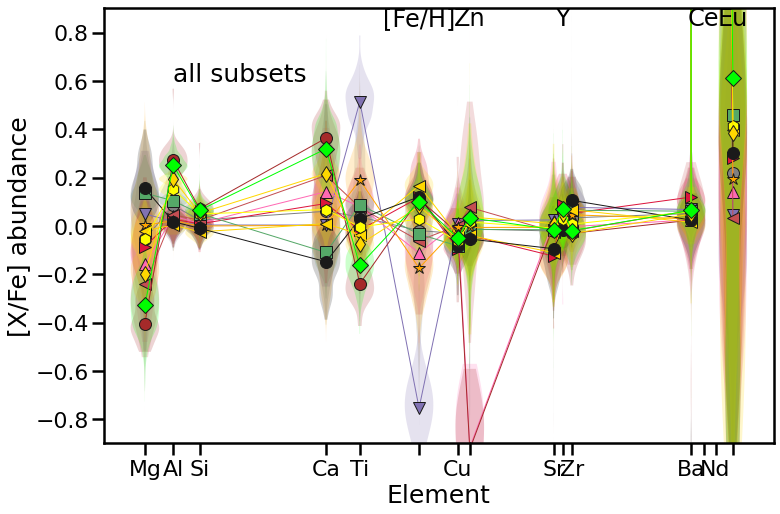

In [59]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

t = apo_rc
what = {"thick":[0,1,2,3,4], "thin":[0,5,7,9],
        "strange": [0,10,11,12,13,14,16,17,18,19]}
inds = "strange"
note = {"thick":r"High-$[\alpha$/Fe] populations",
        "thin":r"Low-$[\alpha$/Fe] populations",
        "strange":r"Peculiar stars"}
Z=[ 12, 13, 14, 20, 22, 26, 29, 30, 38, 39, 40, 56, 58, 60, 63]
Znames = ["Mg", "Al", "Si", "Ca", "Ti", "",
          "Cu", "", "Sr", "", "Zr", "Ba", "", "Nd", ""]
Znames2= ["", "", "", "", "", "[Fe/H]",
          "", "Zn", "", "Y", "", "", "Ce", "", "Eu"]


f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(111)
for kk in np.arange(len(t.subsets)):
#    mask = np.where(t.classcol == t.subsets[kk])[0]
    mask = (t.classcol == t.subsets[kk])
#    mask = np.where(t.classcol == t.subsets[kk])[0]
#    print([t.colors[jj][mask]for jj in np.arange(len(Z))])
#    print(np.nanmedian([t.colors[jj][mask]for jj in np.arange(len(Z))],axis=1))
    if kk < 25:
        violins = ax.violinplot([t.colors[jj][mask]for jj in np.arange(len(Z))],np.log10(Z),t.sym[kk]+'-', widths=0.035, showextrema=False)
        for pc in violins['bodies']:
            pc.set_facecolor(t.col[kk])
            pc.set_alpha(.2)
#            pc.set_alpha(t.al[kk])
        plt.plot(np.log10(Z), np.nanmedian([t.colors[jj][mask]for jj in np.arange(len(Z))],axis=1), t.sym[kk]+'-',
                 c=t.col[kk], alpha=1, ms=12, lw=1, mec="k")
#    else:
 #       plt.plot(np.log10(Z), [t.colors[jj][mask]for jj in np.arange(len(Z))], t.sym[kk]+'-', c=t.col[kk],
  #               alpha=1, ms=12, lw=1, mec="k")
ax.axis([np.log10(Z[0])-.05, np.log10(Z[-1])+0.05, -.9, .9])
ax.set_ylabel(r"[X/Fe] abundance",fontsize=25)
ax.text(np.log10(13),.6, 'all subsets', horizontalalignment='left',fontsize=25)

ax.set_xticks(np.log10(Z))
ax.set_xticklabels([]) #str(zz) for zz in Z
for ii in np.arange(len(Znames2)):
    ax.text(np.log10(Z[ii]), .83, Znames2[ii], horizontalalignment='center')
ax.set_xlabel(r"Element",fontsize=25)
ax.set_xticklabels(Znames)

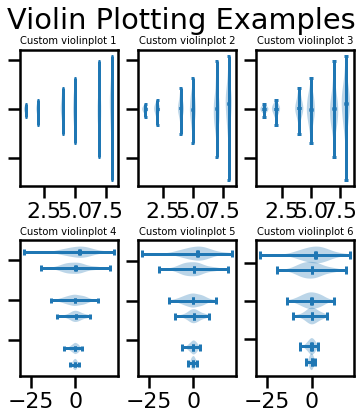

<class 'numpy.ndarray'>


In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


# fake data
fs = 10  # fontsize
pos = [1, 2, 4, 5, 7, 8]
data = [np.random.normal(0, std, size=100) for std in pos]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 6))

axes[0, 0].violinplot(data, pos, points=20, widths=0.3,
                      showmeans=True, showextrema=True, showmedians=True)
axes[0, 0].set_title('Custom violinplot 1', fontsize=fs)

axes[0, 1].violinplot(data, pos, points=40, widths=0.5,
                      showmeans=True, showextrema=True, showmedians=True,
                      bw_method='silverman')
axes[0, 1].set_title('Custom violinplot 2', fontsize=fs)

axes[0, 2].violinplot(data, pos, points=60, widths=0.7, showmeans=True,
                      showextrema=True, showmedians=True, bw_method=0.5)
axes[0, 2].set_title('Custom violinplot 3', fontsize=fs)

axes[1, 0].violinplot(data, pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=True)
axes[1, 0].set_title('Custom violinplot 4', fontsize=fs)

axes[1, 1].violinplot(data, pos, points=100, vert=False, widths=0.9,
                      showmeans=True, showextrema=True, showmedians=True,
                      bw_method='silverman')
axes[1, 1].set_title('Custom violinplot 5', fontsize=fs)

axes[1, 2].violinplot(data, pos, points=200, vert=False, widths=1.1,
                      showmeans=True, showextrema=True, showmedians=True,
                      bw_method=0.5)
axes[1, 2].set_title('Custom violinplot 6', fontsize=fs)

for ax in axes.flat:
    ax.set_yticklabels([])

fig.suptitle("Violin Plotting Examples")
fig.subplots_adjust(hspace=0.4)
plt.show()
print(type(data[1]))

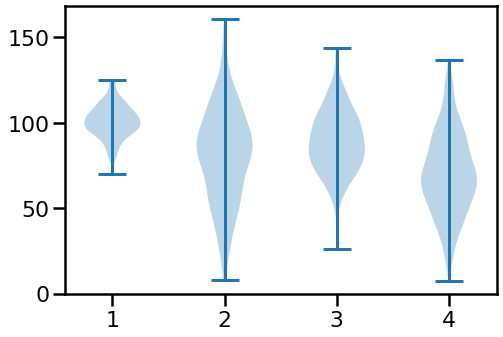

In [11]:
import matplotlib.pyplot as plt

np.random.seed(10)
collectn_1 = np.random.normal(100, 10, 200)
collectn_2 = np.random.normal(80, 30, 200)
collectn_3 = np.random.normal(90, 20, 200)
collectn_4 = np.random.normal(70, 25, 200)

## combine these different collections into a list
data_to_plot = [collectn_1, collectn_2, collectn_3, collectn_4]

# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# Create the boxplot
bp = ax.violinplot(data_to_plot)
plt.show()

In [49]:
sets = "teffcut"                # either 'mc', 'errlim' or 'plain'
what = {"thick":[0,1,2,3,4], "thin":[0,5,7,9],
        "strange": [0,10,11,12,13,14,16,17,18,19]}
note = {"thick":r"High-$[\alpha$/Fe] populations",
        "thin":r"Low-$[\alpha$/Fe] populations",
        "strange":r"Peculiar stars"}

inds = "strange"
Z=[ 12, 13, 14, 20, 22, 26, 29, 30, 38, 39, 40, 56, 58, 60, 63]
for kk in what[inds]:
    print(kk)

0
10
11
12
13
14
16
17
18
19
